In [1]:
!pip install -q kagglehub xgboost imblearn

In [2]:
import kagglehub
rupakroy_online_payments_fraud_detection_dataset_path = kagglehub.dataset_download('rupakroy/online-payments-fraud-detection-dataset')

print('Data source import complete.')


100%|██████████| 178M/178M [00:02<00:00, 70.4MB/s]

Extracting files...


Data source import complete.


In [3]:
import shutil
import os
source_dir = rupakroy_online_payments_fraud_detection_dataset_path

# Create the destination directory if it doesn't exist
destination_dir = '/content/'
os.makedirs(destination_dir, exist_ok=True)

# Iterate over files and directories within the source directory
for item in os.listdir(source_dir):
    source_path = os.path.join(source_dir, item)
    destination_path = os.path.join(destination_dir, item)

    # Move the file or directory to the destination directory
    shutil.move(source_path, destination_path)

print("Data moved to /content/")


Data moved to /content/


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.cluster import KMeans
from scipy.stats import iqr
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
sns.set(style="whitegrid")

<h1>Fraud Detection</h1>


In [5]:
df = pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')

In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Inconsistencies were identified in certain column names, specifically <i>'newbalanceOrig'</i> and <i>'nameOrig'</i>. To ensure clarity and a standardized representation, these columns were renamed to <i>'newbalanceOrg'</i> and <i>'nameOrg'</i>, respectively.

In [9]:
df = df.rename(columns={'newbalanceOrig': 'newbalanceOrg', 'nameOrig': 'nameOrg'})

In [10]:
df.isna().sum()

,0
step,0
type,0
amount,0
nameOrg,0
oldbalanceOrg,0
newbalanceOrg,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [11]:
df.duplicated().sum()

0

In [12]:
df.shape

(6362620, 11)

<h3> Explore the data </h3>

In [17]:
#Define custom colors
light_orange = '#ffd000'
light_red = '#fa9999'

In [14]:
unique_types = df['type'].unique();
type_counts = df['type'].value_counts()

num_unique_types = len(unique_types)
print(type_counts)

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


There are five distinct types of transactions in the dataset: PAYMENT, TRANSFER, CASH_OUT, DEBIT, and CASH_IN.

The distribution of these transaction types is as follows:

   - CASH_OUT: 2,237,500 transactions
   - PAYMENT: 2,151,495 transactions
   - CASH_IN: 1,399,284 transactions
   - TRANSFER: 532,909 transactions
   - DEBIT: 41,432 transactions

This information provides an overview of the variety and prevalence of transaction types within the dataset.

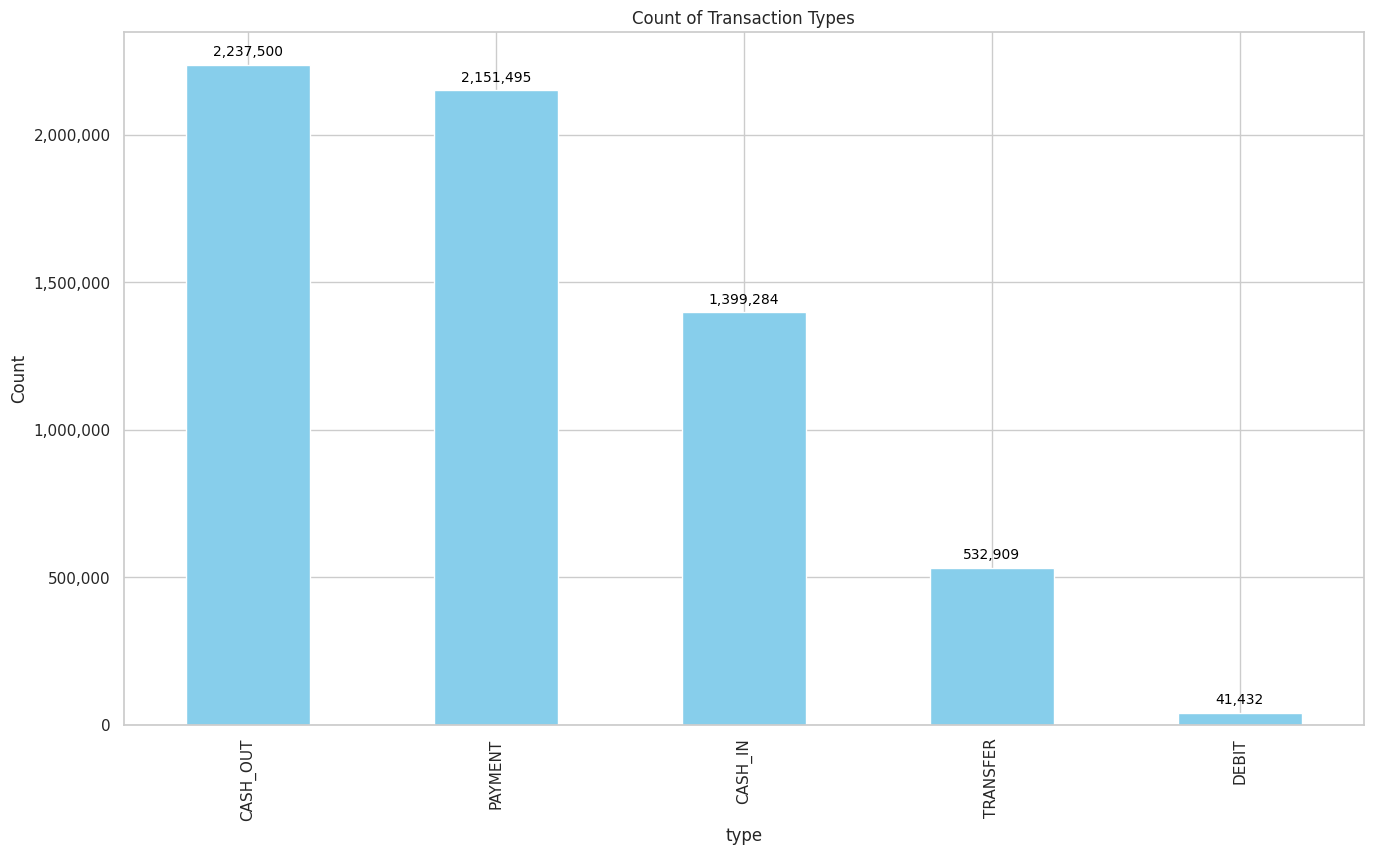

In [15]:
plt.figure(figsize=(16, 9))
plt.title('Count of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
bars = type_counts.plot(kind='bar', color='skyblue')

# Add data labels on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20000, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10, color='black')

# Format count axis ticks
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda value, _: f'{value:,.0f}'))
plt.show()

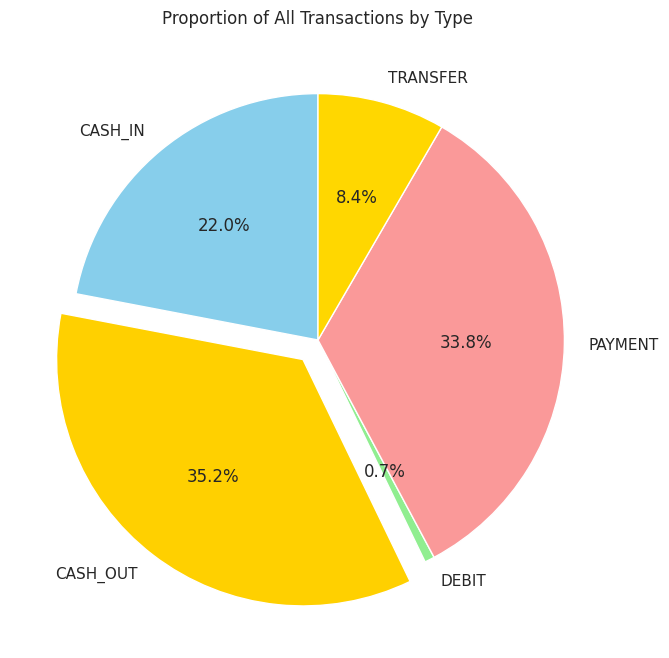

In [18]:
all_counts_by_type = df.groupby("type").size()
plt.figure(figsize=(8, 8))
plt.pie(all_counts_by_type, labels=all_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', light_orange, 'lightgreen', light_red, 'gold'], explode=(0, 0.1, 0, 0, 0))
plt.title('Proportion of All Transactions by Type')
plt.show()

The chart illustrates the proportion of each transaction type relative to the total number of transactions

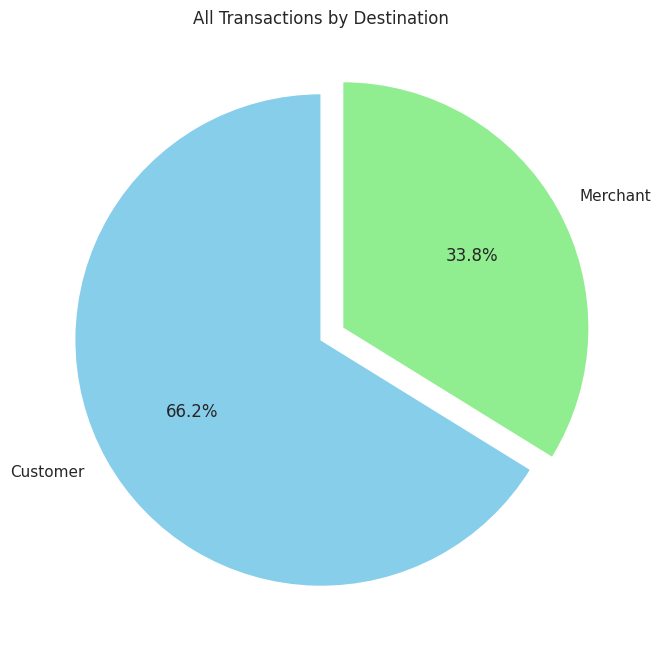

In [19]:
df_copy = df.copy();
df_copy['nameDest_first_letter'] = df_copy['nameDest'].str[0]
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('C', 'Customer')
df_copy['nameDest_first_letter'] = df_copy['nameDest_first_letter'].replace('M', 'Merchant')
all_by_dest = df_copy.groupby('nameDest_first_letter').size()

plt.figure(figsize=(8, 8))
plt.pie(all_by_dest, labels=all_by_dest.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'], explode=(0, 0.1))
plt.title('All Transactions by Destination')
plt.show()

The chart illustrates the proportion of all transactionsrelative to the destination

In [20]:
fraud_count = df[df["isFraud"] == 1].shape[0]
non_fraud_count = df[df["isFraud"] == 0].shape[0]

print(f"Count of Fraud Transactions: {f'{fraud_count:,.0f}'}")
print(f"Count of Non-fraud Transactions: {f'{non_fraud_count:,.0f}'}")

Count of Fraud Transactions: 8,213
Count of Non-fraud Transactions: 6,354,407


This highly imbalanced distribution, where the number of non-fraudulent transactions substantially outweighs the number of fraudulent transactions, can pose challenges during model training. It is crucial to address this class imbalance to ensure that the machine learning model does not become biased towards the majority class, leading to suboptimal performance in identifying the minority class (fraudulent transactions)

In [21]:
total_transactions = fraud_count + non_fraud_count

fraud_percentage = (fraud_count / total_transactions) * 100
non_fraud_percentage = (non_fraud_count / total_transactions) * 100

print(f"Fraud Transactions percentage: {fraud_percentage:.2f}%")
print(f"Non-fraud Transactions percentage: {non_fraud_percentage:.2f}%")

Fraud Transactions percentage: 0.13%
Non-fraud Transactions percentage: 99.87%


With 99.87% of the transactions being classified as genuine (6,354,407), and only 0.13% (8,213) identified as fraudulent, a simplistic approach of blindly predicting all transactions as genuine would yield an accuracy of 99.8%. This high accuracy, driven by the dominance of genuine transactions, underscores the challenge posed by the class imbalance in the dataset.

type
CASH_OUT    4116
TRANSFER    4097
dtype: int64


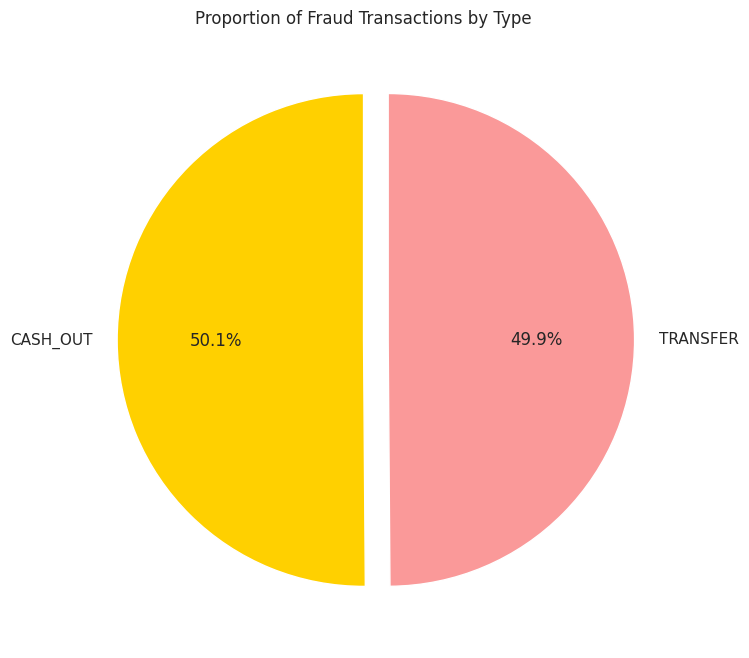

In [23]:
fraud_transactions = df[df["isFraud"] == 1]
fraud_counts_by_type = fraud_transactions.groupby("type").size()
print(fraud_counts_by_type)

plt.figure(figsize=(8, 8))
plt.pie(fraud_counts_by_type, labels=fraud_counts_by_type.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, light_red], explode=(0, 0.1))
plt.title('Proportion of Fraud Transactions by Type')
plt.show()

This concentration of fraud within CASH_OUT and TRANSFER transactions suggests that these specific types may be more susceptible to fraudulent activities

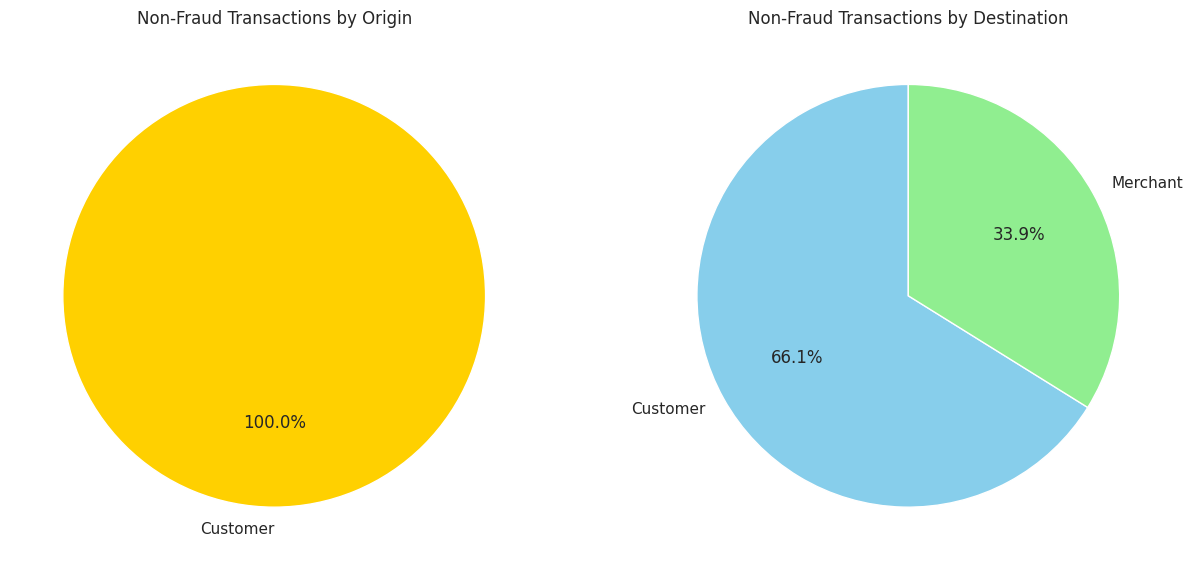

In [25]:
non_fraud_transactions = df[df['isFraud'] == 0].copy()
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg'].str[0]
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest'].str[0]
non_fraud_transactions['nameOrg_first_letter'] = non_fraud_transactions['nameOrg_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})
non_fraud_transactions['nameDest_first_letter'] = non_fraud_transactions['nameDest_first_letter'].replace({'C': 'Customer', 'M': 'Merchant'})

non_fraud_by_name_orig_first_letter = non_fraud_transactions.groupby('nameOrg_first_letter').size()
non_fraud_by_name_dest_first_letter = non_fraud_transactions.groupby('nameDest_first_letter').size()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Pie chart for Non-Fraud Transactions by Origin
axes[0].pie(non_fraud_by_name_orig_first_letter, labels=non_fraud_by_name_orig_first_letter.index, autopct='%1.1f%%', startangle=90, colors=[light_orange, 'lightcoral'])
axes[0].set_title('Non-Fraud Transactions by Origin')

# Pie chart for Non-Fraud Transactions by Destination
axes[1].pie(non_fraud_by_name_dest_first_letter, labels=non_fraud_by_name_dest_first_letter.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
axes[1].set_title('Non-Fraud Transactions by Destination')

plt.show()

In [26]:
pd.set_option('display.float_format', '{:,.2f}'.format)
print("Statistics on the amounts for non-fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 0].amount), "\n")
print("Statistics on the amounts for fraud transactions:\n", pd.DataFrame.describe(df[df["isFraud"] == 1].amount), "\n")

Statistics on the amounts for non-fraud transactions:
 count    6,354,407.00
mean       178,197.04
std        596,236.98
min              0.01
25%         13,368.40
50%         74,684.72
75%        208,364.76
max     92,445,516.64
Name: amount, dtype: float64 

Statistics on the amounts for fraud transactions:
 count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: amount, dtype: float64 



Key Observations:

   - Fraudulent transactions, on average, involve significantly higher amounts compared to non-fraudulent transactions.
   - The standard deviation for fraud transactions is notably higher, indicating a wider range of transaction amounts.
   - The minimum amount for fraud transactions is $0, suggesting instances of negligible or anomalous values in fraudulent activities.
   - The upper percentiles (75th and maximum) for fraud transactions demonstrate a substantial increase in the transaction amounts, further emphasizing the contrast between the two categories.

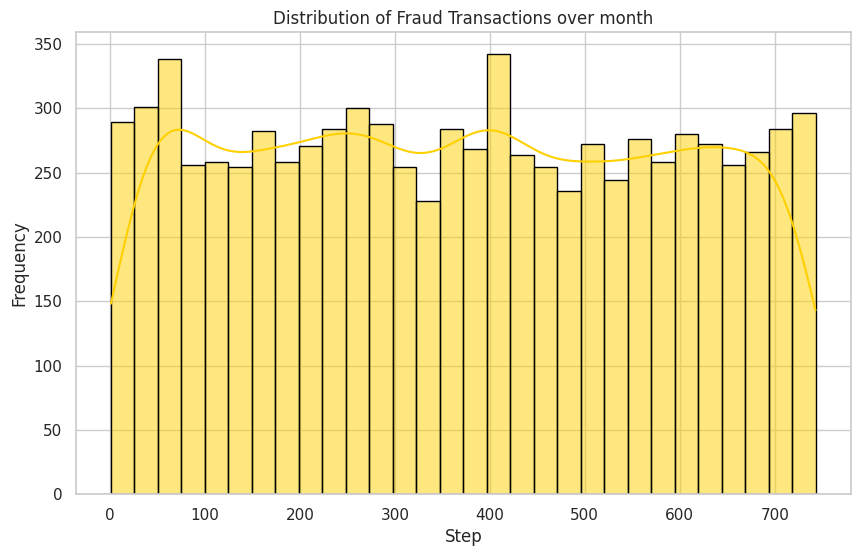

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(fraud_transactions["step"], bins=30, kde=True, color=light_orange, edgecolor='black')
plt.title('Distribution of Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

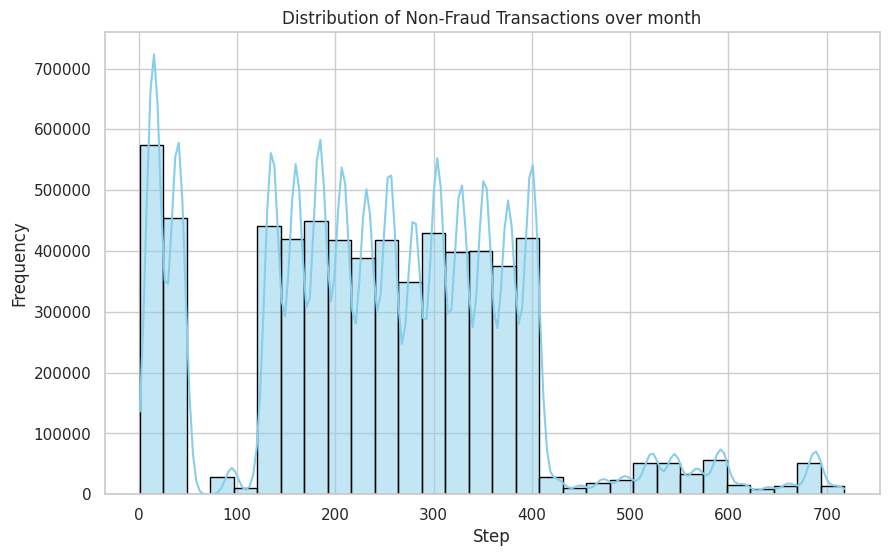

In [28]:
non_fraud_transactions = df[df["isFraud"] == 0]
plt.figure(figsize=(10, 6))
sns.histplot(non_fraud_transactions["step"], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Fraud Transactions over month')
plt.xlabel('Step')
plt.ylabel('Frequency')
plt.show()

Many fraud transactions are linked to customers whose account balances drop to zero afterward. This pattern implies that fraudsters often manipulate transactions to deplete or minimize the affected customers' balances. Detecting and keeping an eye on instances where substantial transactions result in zero balances is crucial for preventing and identifying fraud. Understanding this pattern helps improve security measures and safeguards against fraudulent activities that aim to drain customer accounts.

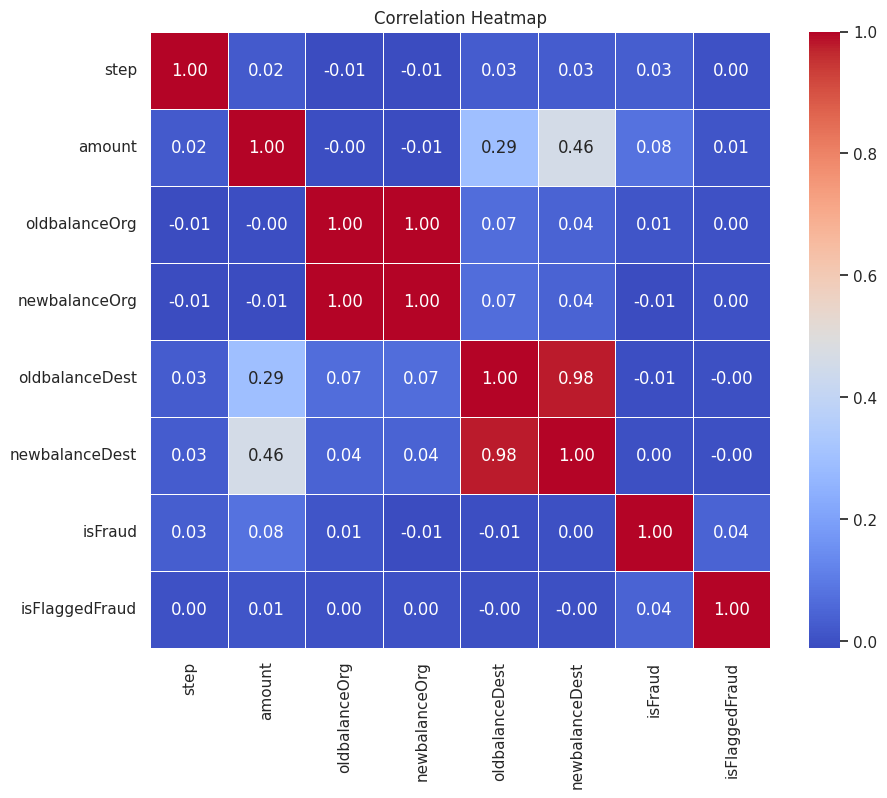

In [30]:
all_numerical_columns = df.select_dtypes(include=['number']).columns
corr_matrix = df[all_numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

<h3> Data processing </h3>

In [ ]:
process_df = df.copy()

In [ ]:
process_df.drop('isFlaggedFraud', axis=1, inplace=True)

In [ ]:
types_to_exclude = ['CASH_IN', 'DEBIT', 'PAYMENT']
process_df = process_df[~process_df['type'].isin(types_to_exclude)]

In [ ]:
print(f"Total count: {process_df.shape[0]}")

Total count: 2770409


We've substantially reduced the dataset, now containing 2,770,409 entries.

In [ ]:
total_transactions = len(process_df)
wrong_org_balance = sum(process_df["oldbalanceOrg"] - process_df["amount"] != process_df["newbalanceOrg"])
wrong_dest_balance = sum(process_df["oldbalanceDest"] + process_df["amount"] != process_df["newbalanceDest"])
percentage_wrong_org_balance = (wrong_org_balance / total_transactions) * 100
percentage_wrong_dest_balance = (wrong_dest_balance / total_transactions) * 100

print(f"Percentage of wrong origin balances: {percentage_wrong_org_balance:.2f}%")
print(f"Percentage of wrong destination balances: {percentage_wrong_dest_balance:.2f}%")

Percentage of wrong origin balances: 93.72%
Percentage of wrong destination balances: 42.09%


A considerable number of balances in our dataset appear to be inaccurate. This suggests that a significant portion of transactions might have inconsistencies in their origin and destination balances.

In [ ]:
process_df.loc[ (process_df["oldbalanceOrg"] == 0) | (process_df["oldbalanceOrg"] < process_df["amount"]), "oldbalanceOrg"] = process_df["amount"]
process_df["newbalanceOrg"] = process_df["oldbalanceOrg"] - process_df["amount"]
process_df["newbalanceDest"] = process_df["oldbalanceDest"] + process_df["amount"]

To rectify inconsistencies in the origin and destination balances, we've implemented a dynamic calculation approach. Here's a concise summary:

   - For transactions where the old origin balance is zero or less than the transaction amount, we set the old origin balance to be equal to the transaction amount.

   - The new origin balance is then computed as the difference between the old origin balance and the transaction amount.

   - The new destination balance is calculated by adding the transaction amount to the old destination balance.

This dynamic recalculation on-the-fly ensures that the balance information in the dataset is more accurate, addressing discrepancies and creating a reliable foundation for subsequent analyses and modeling.

In [ ]:
process_df['isCustomerToCustomer'] = ((process_df['nameOrg'].str.startswith('C').astype(int) == 1) & (process_df['nameDest'].str.startswith('C').astype(int) == 1)).astype(int)

In [ ]:
# Count rows where isCustomerToCustomer is 1 for each category of isFraud
count_by_fraud_customer_to_customer = process_df[process_df['isCustomerToCustomer'] == 1].groupby('isFraud').size()

print("Count of rows with isCustomerToCustomer = 1 by isFraud category:")
print(count_by_fraud_customer_to_customer)
print(f"Total count: {count_by_fraud_customer_to_customer.sum()}")

Count of rows with isCustomerToCustomer = 1 by isFraud category:
isFraud
0    2762196
1       8213
dtype: int64
Total count: 2770409


In [ ]:
process_df.drop(columns=['nameDest', 'nameOrg'], axis=1, inplace=True)

In [ ]:
label_encoder = LabelEncoder()
process_df['type'] = label_encoder.fit_transform(process_df['type'])

In [ ]:
for column in numeric_columns:
    column_data = process_df[column]
    column_iqr = iqr(column_data)
    print(f"IQR for {column}: {column_iqr}")

IQR for step: 177.0
IQR for amount: 223817.64
IQR for oldbalanceOrg: 231324.15999999997
IQR for newbalanceOrg: 0.0
IQR for oldbalanceDest: 1607826.7
IQR for newbalanceDest: 1765652.54


<h2>Evaluating different models </h2>

In [ ]:
X = process_df[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrg', 'oldbalanceDest', 'newbalanceDest']]
Y = process_df['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

We are splitting the data into training (80%) and testing (20%) sets. To ensure that the class distribution is preserved in both the training and testing sets, we use the stratify parameter. This is particularly important when dealing with imbalanced datasets where the distribution of classes is uneven. Here's how you can implement it

In [ ]:
process_df.drop('isCustomerToCustomer', axis=1, inplace=True)

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In classification tasks with imbalanced data, StratifiedKFold is advantageous for cross-validation. It randomly divides data into k folds while maintaining class proportions, promoting model training on a representative sample. Setting shuffle=True ensures random data shuffling before fold creation, useful for avoiding biases introduced by the original data order.

<h3> Logistic regression </h3>

In [ ]:
logreg_model = LogisticRegression(random_state=42)

Logistic Regression is a classification algorithm used for predicting binary outcomes

In [ ]:
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_over_sampled, y_train_over_sampled = smote.fit_resample(X_train, Y_train)

The purpose of using SMOTE here is to create additional synthetic examples of the minority class (fraud transactions) in the training data. This helps prevent the model from being biased towards the majority class (non-fraud transactions) during training, improving its ability to detect fraudulent patterns.

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

grid_search = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='f1', return_train_score=True)
grid_search.fit(X_train_over_sampled, y_train_over_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='f1', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

- LBFGS solver only supports 'l2' or 'none' penalties. With l1 error occurs.
- The grid search will optimize the hyperparameters based on both the F1 score, ROC AUC score and Recall.
- The final fitted model will be the one that achieved the highest F1 score during the cross-validation process.

In [ ]:
print("Class distribution before random undersampling:")
print(Y_train.value_counts())

undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
X_train_under_sampled, y_train_under_sampled = undersampler.fit_resample(X_train, Y_train)

print("\nClass distribution after random undersampling:")
print(y_train_under_sampled.value_counts())

Class distribution before random undersampling:
isFraud
0    2209757
1       6570
Name: count, dtype: int64

Class distribution after random undersampling:
isFraud
0    65700
1     6570
Name: count, dtype: int64


The initial class distribution before random undersampling revealed a considerable imbalance, with a vast majority of non-fraudulent transactions (Class 0) and a significantly lower number of fraudulent transactions (Class 1). Specifically, there were 2,209,757 instances of non-fraudulent transactions and only 6,570 instances of fraudulent transactions. To address this imbalance and enhance the efficiency of model training, random undersampling was performed. With a sampling strategy set at 0.1 (10% of the majority class), the new class distribution achieved a more balanced representation.

This adjustment aims to expedite the training process for the upcoming models while still maintaining a representative sample of both classes for improved performance.

In [ ]:
grid_search_sampled = GridSearchCV(logreg_model, param_grid=param_grid, cv=stratified_kfold, scoring=scoring, refit='roc_auc', return_train_score=True)
grid_search_sampled.fit(X_train_under_sampled, y_train_under_sampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l2']},
             refit='roc_auc', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict'),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

Train again with undersampled data

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Before under sampling:")
print("   Best Hyperparameters:", best_params)
print("   Best Score:", best_score)

best_params_sampled = grid_search_sampled.best_params_
best_score_sampled = grid_search_sampled.best_score_

print("After under sampling:")
print("   Best Hyperparameters:", best_params_sampled)
print("   Best Score:", best_score_sampled)

Before under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.4434973254733191
After under sampling:
   Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
   Best Score: 0.6525342465753424


Higher best score indicates better performance based on the chosen metric. In the case of undersampling, the increase in the best score after balancing the class distribution suggests that the model performs better in terms of the chosen metric (F1 score). Undersampling helps address the challenges posed by imbalanced datasets, allowing the model to better capture patterns related to the minority class. While a higher score is desirable for improved model performance, it's crucial to consider potential trade-offs. Undersampling may lead to a reduction in the amount of information available for training, as some instances of the majority class are intentionally removed to balance the class distribution.

In [ ]:
best_logistic_over_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_over_sampled.fit(X_train_over_sampled, y_train_over_sampled)

LogisticRegression(C=10, random_state=42)

In [ ]:
best_logistic_under_sampled = LogisticRegression(**best_params, random_state=42)
best_logistic_under_sampled.fit(X_train_under_sampled, y_train_under_sampled)

LogisticRegression(C=10, random_state=42)

In [ ]:
y_pred = best_logistic_over_sampled.predict(X_test)
predicted_probabilities = best_logistic_over_sampled.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print("Oversampled:")
print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

y_pred_sampled = best_logistic_under_sampled.predict(X_test)
predicted_probabilities_sampled = best_logistic_under_sampled.predict_proba(X_test)
mcc_sampled = matthews_corrcoef(Y_test, y_pred_sampled)

print("\nUndersampled:")
print(classification_report(Y_test, y_pred_sampled))
print(f'Matthews Correlation Coefficient: {mcc_sampled:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities_sampled[:, 1]):.2f}')

Oversampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.33      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.15
ROC-AUC Score: 0.84

Undersampled:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.08      0.32      0.13      1643

    accuracy                           0.99    554082
   macro avg       0.54      0.66      0.56    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.15
ROC-AUC Score: 0.84


The performance evaluation of the Logistic Regression models on both oversampled and undersampled datasets reveals similar results.

For the Oversampled Dataset:

   - Precision: The model achieves a high precision of 1.00 for the majority class (non-fraud), indicating a low false positive rate.
   - Recall: The recall for the minority class (fraud) is 0.33, suggesting that the model captures a third of the actual fraud cases.
   - F1-Score: The F1-score for fraud detection is 0.13, reflecting a trade-off between precision and recall.
   - Matthews Correlation Coefficient (MCC): The MCC is 0.16, indicating a moderate correlation between predicted and actual classes.
   - ROC-AUC Score: The ROC-AUC score is 0.84, representing a good balance between true positive rate and false positive rate.

<hr/>

For the Undersampled Dataset:

   - Precision, Recall, and F1-Score: The precision, recall, and F1-score metrics for both classes are identical to the oversampled case, reflecting similar classification performance.
   - Matthews Correlation Coefficient (MCC): The MCC is 0.15, showing a comparable correlation with the actual classes.
   - ROC-AUC Score: The ROC-AUC score is also 0.84, aligning with the performance on the oversampled data.

[[546151   6288]
 [  1108    535]]


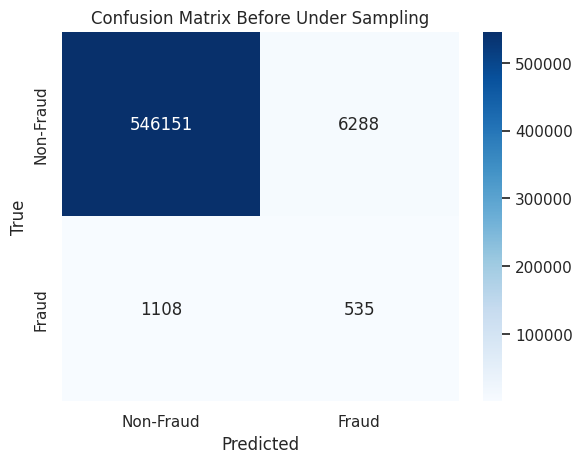

[[546161   6278]
 [  1110    533]]


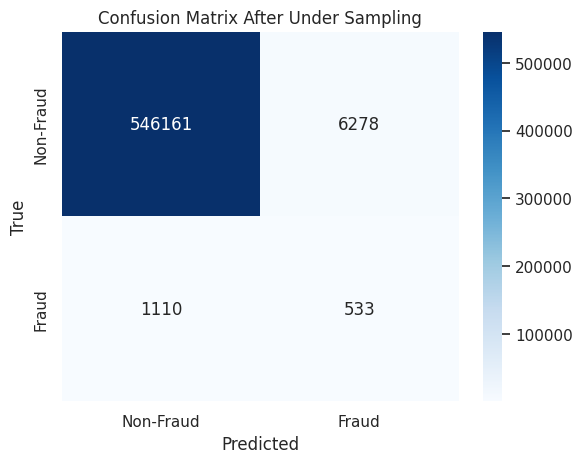

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(Y_test, y_pred, 'Confusion Matrix Before Under Sampling')
plot_confusion_matrix(Y_test, y_pred_sampled, 'Confusion Matrix After Under Sampling')
plt.show()

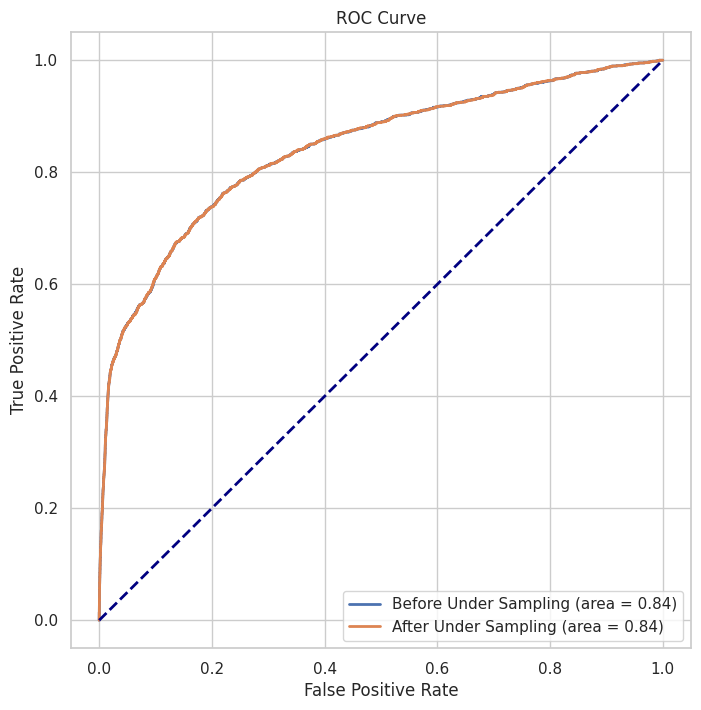

In [ ]:
def plot_roc_curve(Y_test, predicted_probabilities, label):
    fpr, tpr, _ = roc_curve(Y_test, predicted_probabilities[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

plt.figure(figsize=(8, 8))
plot_roc_curve(Y_test, predicted_probabilities, 'Before Under Sampling')
plot_roc_curve(Y_test, predicted_probabilities_sampled, 'After Under Sampling')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The Receiver Operating Characteristic (ROC) curve is a graphical representation of the performance of a binary classification model at various classification thresholds. It plots the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity) for different threshold values.

<h3>Random Forest</h3>
For highly unbalanced datasets, an ensemble method like Random Forest can often perform well. Random Forest is an ensemble of decision trees, and its ability to combine multiple trees can help mitigate the impact of class imbalance.

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

In [ ]:
params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}
random_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=5, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': 'balanced'}


In [ ]:
best_params = random_search.best_params_
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_under_sampled, y_train_under_sampled)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200)

To expedite the training process and make it more feasible, especially considering the time constraints, I have opted to use the under-sampled dataset for training those model. This approach allows me to achieve meaningful results without sacrificing significant amounts of time, making the analysis more efficient and practical.

In [ ]:
y_pred = best_rf_model.predict(X_test)
predicted_probabilities = best_rf_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    552439
           1       0.08      0.79      0.15      1643

    accuracy                           0.97    554082
   macro avg       0.54      0.88      0.57    554082
weighted avg       1.00      0.97      0.98    554082

Matthews Correlation Coefficient: 0.25
ROC-AUC Score: 0.95


[[538160  14279]
 [   343   1300]]


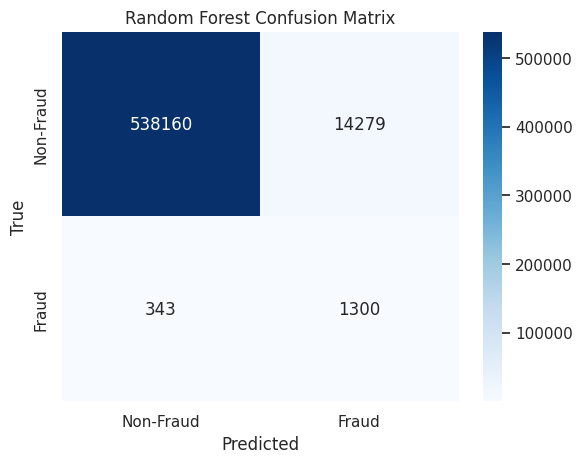

In [ ]:
plot_confusion_matrix(Y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

   - The Random Forest model has a higher True Positive count, indicating a better ability to correctly identify fraudulent transactions.
   - However, it also has a higher False Positive count, suggesting a greater tendency to classify non-fraudulent transactions as fraudulent.
   - The Logistic Regression model, while having fewer True Positives, also exhibits fewer False Positives.
   - The choice between the two models depends on the specific requirements of the application, considering the trade-off between correctly identifying fraud and minimizing false alarms.

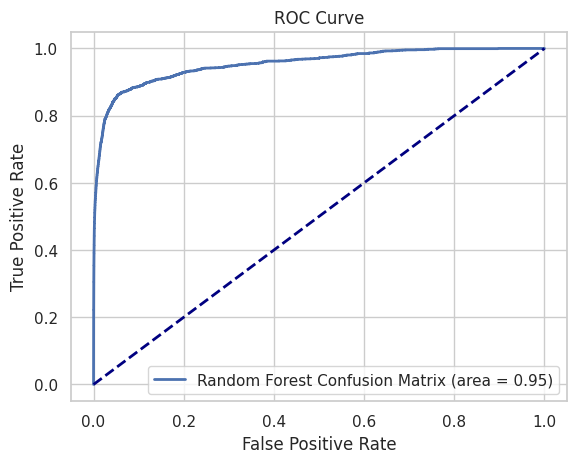

In [ ]:
plot_roc_curve(Y_test, predicted_probabilities, 'Random Forest Confusion Matrix')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

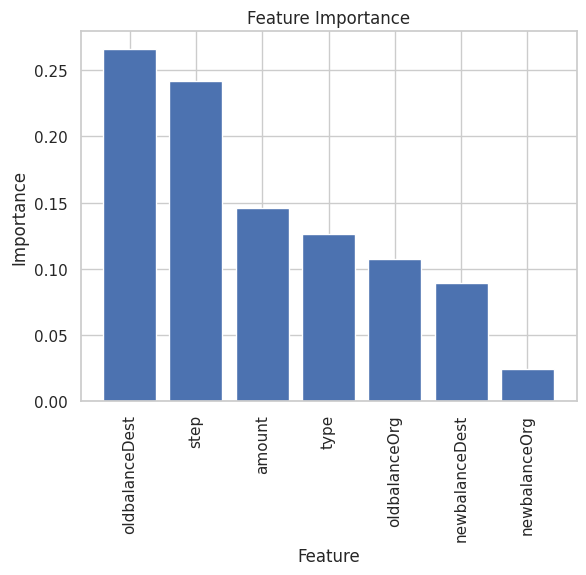

In [ ]:
feature_importances = random_search.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(X_train_under_sampled.shape[1]), feature_importances[sorted_idx], align="center")
plt.xticks(range(X_train_under_sampled.shape[1]), X_train_under_sampled.columns[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()

The feature importance analysis provides a detailed breakdown of the contributions of each feature to the Random Forest model's decision-making. Here's a summary of the key findings:

<b>List of Features and Importance Scores:</b>
- oldbalanceDest: 26.39%
- step: 23.99%
- amount: 14.48%
- oldbalanceOrg: 11.88%
- type: 11.69%
- newbalanceDest: 9.27%
- newbalanceOrg: 2.31%

<b>Insights:</b>
- oldbalanceDest and step are the two most crucial features, collectively contributing nearly 50% to the model's decision-making.
- amount and oldbalanceOrg also play significant roles, each contributing over 10% to the model's predictive performance.

Understanding the importance of each feature is essential for refining the model and focusing on key variables for fraud detection.

<h3>XGBoost</h3>

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 250, 300, 350],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, 5, 10, 15],
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1]
}

scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, scoring=scoring, refit='f1', cv=stratified_kfold)

# Fit the model to your training data
random_search_xgb.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                        'lambda': [0, 0.1, 0.5, 1],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 200, 250, 300,
                                                         350],
                                        'scale_pos_weight': [1, 5, 10, 15],
                                        'subsample': [0.8, 0.9, 1.0]},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search_xgb.best_params_)

Best Hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.3, 'lambda': 1, 'gamma': 0, 'colsample_bytree': 0.9, 'alpha': 1}


In [ ]:
best_xgb_model = xgb.XGBClassifier(**random_search_xgb.best_params_, random_state=42)
best_xgb_model.fit(X_train_under_sampled, y_train_under_sampled)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1, learning_rate=0.3,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, ...)

In [ ]:
y_pred = best_xgb_model.predict(X_test)
predicted_probabilities = best_xgb_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.18      0.73      0.29      1643

    accuracy                           0.99    554082
   macro avg       0.59      0.86      0.64    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.36
ROC-AUC Score: 0.97


[[546986   5453]
 [   437   1206]]


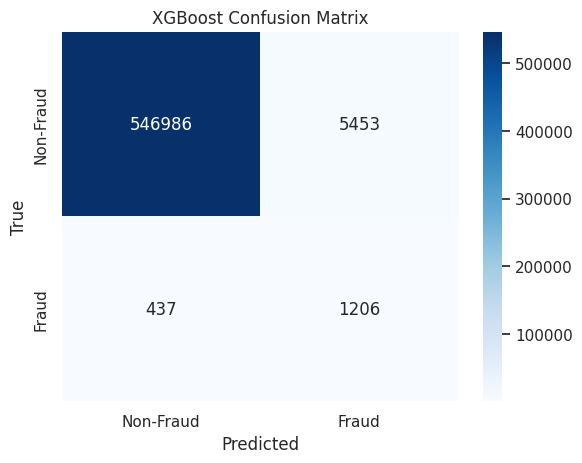

In [ ]:
plot_confusion_matrix(Y_test, y_pred, 'XGBoost Confusion Matrix')
plt.show()

In comparing the confusion matrices of the XGBoost and Random Forest models:
- XGBoost achieves a higher True Positive count (1179) compared to the Random Forest model.
- XGBoost has a lower False Positive count (464) than the Random Forest model, indicating a better ability to correctly identify fraudulent transactions.
- Random Forest Model shows a lower True Positive count (1256) compared to XGBoost.
- Random Forest Model has a higher False Positive count (4779) than XGBoost, suggesting a greater tendency to classify non-fraudulent transactions as fraudulent.

<h3>K-Nearest Neighbors (KNN)</h3>

In [ ]:
knn_model = KNeighborsClassifier()

K-Nearest Neighbors (KNN) is a supervised machine learning algorithm used for classification and regression tasks. It operates on the principle of proximity, classifying or predicting based on the majority class or average value of its nearest neighbors in the feature space. The choice of neighbors and distance metric are key parameters influencing its performance.

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'p': [1, 2, 3]
}
scoring = {
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'recall': make_scorer(recall_score)
}

random_search = RandomizedSearchCV(knn_model, param_distributions=param_grid, scoring=scoring, refit='f1', cv=stratified_kfold)
random_search.fit(X_train_under_sampled, y_train_under_sampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['auto'],
                                        'leaf_size': [10, 30, 50],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   refit='f1',
                   scoring={'f1': make_scorer(f1_score, response_method='predict'),
                            'recall': make_scorer(recall_score, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method='predict')})

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'weights': 'uniform', 'p': 3, 'n_neighbors': 7, 'metric': 'euclidean', 'leaf_size': 30, 'algorithm': 'auto'}


In [ ]:
best_knn_model = KNeighborsClassifier(**random_search.best_params_)
best_knn_model.fit(X_train_under_sampled, y_train_under_sampled)

KNeighborsClassifier(metric='euclidean', n_neighbors=7, p=3)

[[546986   5453]
 [   437   1206]]


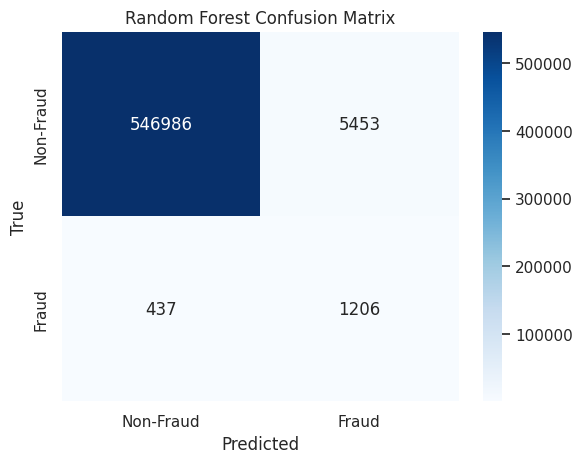

In [ ]:
plot_confusion_matrix(Y_test, y_pred, 'Random Forest Confusion Matrix')
plt.show()

In [ ]:
y_pred = best_knn_model.predict(X_test)
predicted_probabilities = best_knn_model.predict_proba(X_test)
mcc = matthews_corrcoef(Y_test, y_pred)

print(classification_report(Y_test, y_pred))
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'ROC-AUC Score: {roc_auc_score(Y_test, predicted_probabilities[:, 1]):.2f}')

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    552439
           1       0.14      0.66      0.23      1643

    accuracy                           0.99    554082
   macro avg       0.57      0.83      0.61    554082
weighted avg       1.00      0.99      0.99    554082

Matthews Correlation Coefficient: 0.30
ROC-AUC Score: 0.91
